### Preface
Right now it only contains a dataloader for the drive dataset.
I have tested with my personal computer so the path and such needs to be changed to run on the HPC etc.

In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image

# pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time

import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

### Tested locally so change the path to the correct distination (HPC)! 

In [2]:
# Dataloader for the drive dataset
class DRIVE_Dataloader(torch.utils.data.Dataset):
    def __init__(self, image_paths, mask_paths=None, transform_image=None, transform_mask=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths  # No mask path for test set
        self.transform_image = transform_image  
        self.transform_mask = transform_mask  

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        mask = Image.open(self.mask_paths[idx])

        
        if self.transform_image and self.transform_mask:
            # Apply the same transformation to both image and mask
            seed = torch.seed()  # Set random seed so same transformation is applied to both
            torch.manual_seed(seed)
            image = self.transform_image(image)
            torch.manual_seed(seed)
            mask = self.transform_mask(mask)
        
        # Convert to binary but kept float
        mask = torch.tensor(mask, dtype=torch.float32) 
        mask = (mask > 0).float() 
        
        return image, mask


path = r'C:/Users/Frederik/Downloads/DRIVE' # Personal path, change to HPC data path. 
#path = r"/dtu/datasets1/02516/DRIVE"

size = 256
batch_size = 6
num_workers = 0 # Should be higher when running on HPC.

# Pathing for the images in the folders
train_images = sorted(glob.glob(os.path.join(path, 'training', 'images', '*.TIF')))
# Choosing retinal blood vessel mask instead of the FOV mask
train_masks = sorted(glob.glob(os.path.join(path, 'training', '1st_manual', '*.GIF')))

# I chose 80/20 train-val split
train_img_paths, val_img_paths, train_mask_paths, val_mask_paths = train_test_split(
    train_images, train_masks, test_size=0.2)

# split the val now into test and val
val_img_paths, test_img_paths, val_mask_paths, test_mask_paths = train_test_split(
    val_img_paths, val_mask_paths, test_size=0.5)


# Test set where we
#test_images = sorted(glob.glob(os.path.join(path, 'test', 'images', '*.TIF')))

# Data augmentation for both images and masks
train_image_transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.RandomHorizontalFlip(), # Flips of horizontal and vertical nature here seems appropiae so I included them 
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),  
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1), # Changes these values very slightly which 
    #                                                                     I think aligns with what we seen on training images. 
    transforms.ToTensor(),
])

train_mask_transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15), 
    transforms.ToTensor(),
])

# For validation/test
val_transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
])

trainset = DRIVE_Dataloader(image_paths=train_img_paths, mask_paths=train_mask_paths, transform_image=train_image_transform, transform_mask=train_mask_transform)
valset = DRIVE_Dataloader(image_paths=val_img_paths, mask_paths=val_mask_paths, transform_image=val_transform, transform_mask=val_transform)
testset = DRIVE_Dataloader(image_paths=test_img_paths, mask_paths=test_mask_paths,transform_image=val_transform, transform_mask=val_transform)

train_loader_drive = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader_drive = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader_drive = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)



In [34]:
class PH2_Dataloader(torch.utils.data.Dataset):
    def __init__(self, image_paths, mask_paths, transform_image=None, transform_mask=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform_image = transform_image  
        self.transform_mask = transform_mask  

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        mask = Image.open(self.mask_paths[idx])
        
        if self.transform_image and self.transform_mask:
            # Apply the same transformation to both image and mask
            seed = torch.seed()  # Set random seed so same transformation is applied to both
            torch.manual_seed(seed)
            image = self.transform_image(image)
            torch.manual_seed(seed)
            mask = self.transform_mask(mask)
        
        return image, mask
    
path = r'C:/Users/Frederik\Downloads/PH2_Dataset_images' # Personal path, change to HPC data path. 
#path = r"/dtu/datasets1/02516/PH2_Dataset_images"

size = 256//2 ## wanted to use 256 but testing was too slow on local PC. 
batch_size = 16
num_workers = 0 # Should be higher when running on HPC.

image_paths = sorted(glob.glob(os.path.join(path, "IMD*","IMD*_Dermoscopic_Image",'*.BMP')))
mask_paths = sorted(glob.glob(os.path.join(path, "IMD*","IMD*_lesion", '*.BMP')))


## TODO Appropiate transformations
image_transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
])

mask_transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
])

# For validation/test
test_val_transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
])


# First, split into 80% train and 20% val+test
train_img_paths, val_test_img_paths, train_mask_paths, val_test_mask_paths = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42)

# Split the remaining 20% into validation and test
val_img_paths, test_img_paths, val_mask_paths, test_mask_paths = train_test_split(
    val_test_img_paths, val_test_mask_paths, test_size=0.5, random_state=42)

trainset = PH2_Dataloader(image_paths=train_img_paths, mask_paths=train_mask_paths, transform_image=image_transform, transform_mask=mask_transform)
valset = PH2_Dataloader(image_paths=val_img_paths, mask_paths=val_mask_paths, transform_image=test_val_transform , transform_mask=test_val_transform)
testset = PH2_Dataloader(image_paths=test_img_paths, mask_paths=test_mask_paths, transform_image=test_val_transform )

train_loader_ph2 = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader_ph2 = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader_ph2 = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


In [4]:
print('Loaded %d training images' % len(trainset))
print('Loaded %d val images' % len(valset))
print('Loaded %d test images' % len(testset))

Loaded 16 training images
Loaded 2 val images
Loaded 2 test images


Unique values in masks:

C:\Users\Frederik\AppData\Local\Temp\ipykernel_24944\4291406222.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


 tensor([0., 1.])


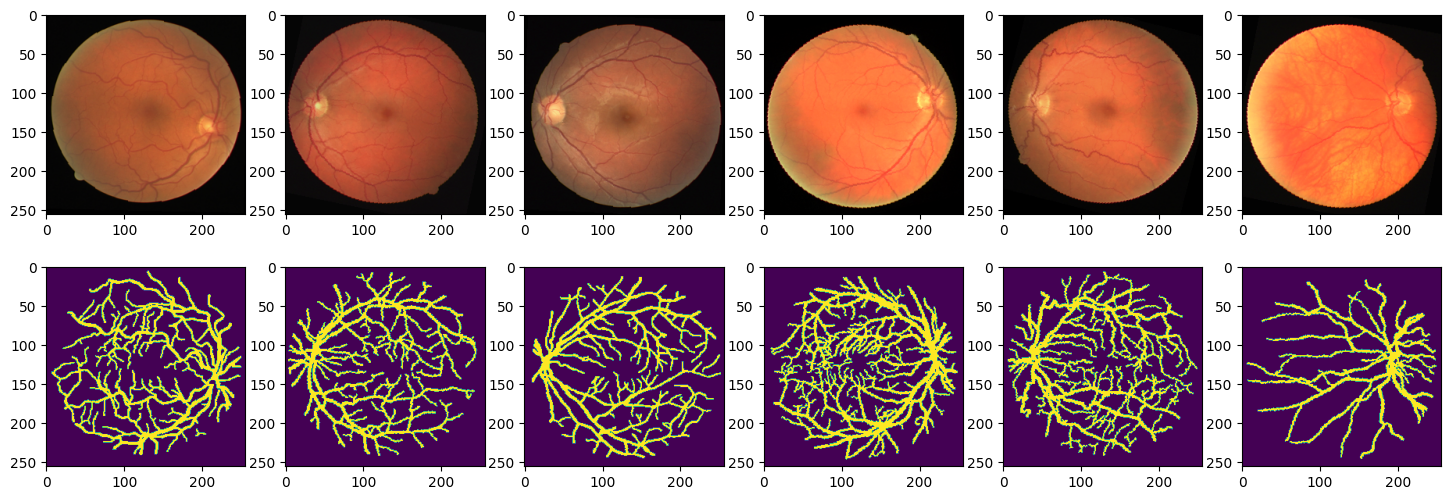

In [5]:
# Image preview with image and mask
plt.rcParams['figure.figsize'] = [18, 6]

images, masks = next(iter(train_loader_drive))

# Print the unique values in masks
print("Unique values in masks:", torch.unique(masks))

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i], 0, 2), 0, 1))

    plt.subplot(2, 6, i+7)
    plt.imshow(masks[i].squeeze())
plt.show()

Unique values in masks: tensor([0., 1.])


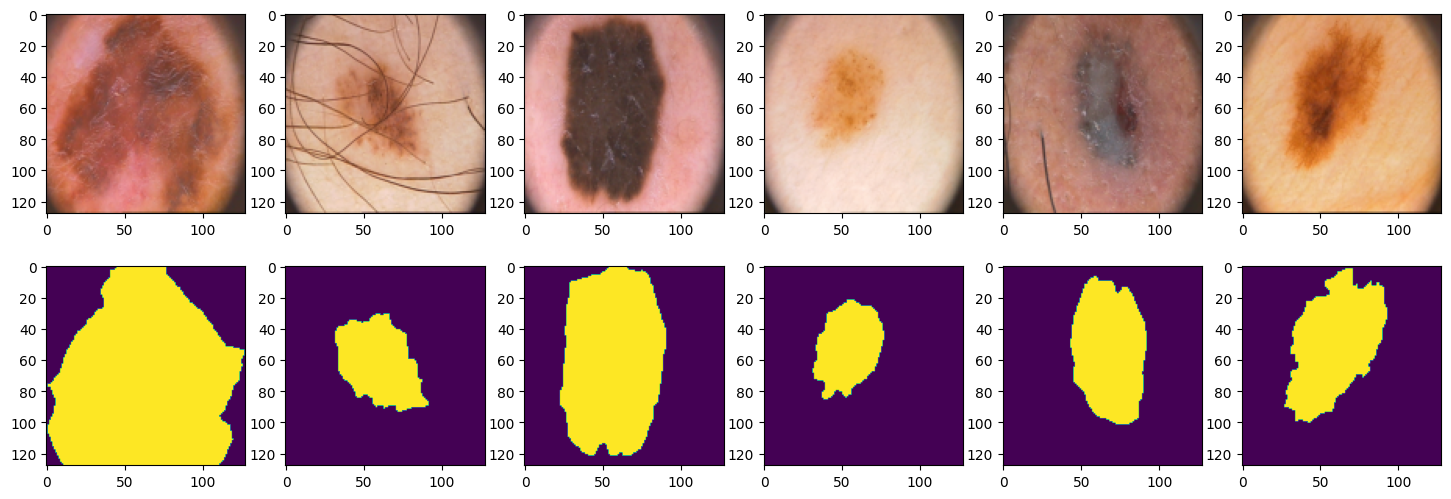

In [35]:
# Image preview with image and mask
plt.rcParams['figure.figsize'] = [18, 6]

images, masks = next(iter(train_loader_ph2))

# Print the unique values in masks
print("Unique values in masks:", torch.unique(masks))

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i], 0, 2), 0, 1))

    plt.subplot(2, 6, i+7)
    plt.imshow(masks[i].squeeze())
plt.show()

In [6]:
# check if cuda active
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [7]:
# Encoder network with small modifications from exercise 2.2.
class EncDec(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.pool0 = nn.MaxPool2d(2, 2)  # 128 -> 64
        self.enc_conv1 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # 64 -> 32
        self.enc_conv2 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # 32 -> 16
        self.enc_conv3 = nn.Conv2d(256, 512, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)  # 16 -> 8

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(512, 1024, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='bilinear' )  # 8 -> 16
        self.dec_conv0 = nn.Conv2d(1024, 512, 3, padding=1)
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear' )  # 16 -> 32
        self.dec_conv1 = nn.Conv2d(512, 256, 3, padding=1)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear' )  # 32 -> 64
        self.dec_conv2 = nn.Conv2d(256, 128, 3, padding=1)
        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear' )  # 64 -> 128
        self.dec_conv3 = nn.Conv2d(128, 64, 3, padding=1)
        self.final_conv = nn.Conv2d(64, 1, 1)  # changed to greyscale output for the mask. (Exercise 2.2 had 3 channels so maybe change back?)

    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.enc_conv0(x)))
        e1 = self.pool1(F.relu(self.enc_conv1(e0)))
        e2 = self.pool2(F.relu(self.enc_conv2(e1)))
        e3 = self.pool3(F.relu(self.enc_conv3(e2)))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        d0 = F.relu(self.dec_conv0(self.upsample0(b)))
        d1 = F.relu(self.dec_conv1(self.upsample1(d0)))
        d2 = F.relu(self.dec_conv2(self.upsample2(d1)))
        d3 = F.relu(self.dec_conv3(self.upsample3(d2)))

        out = self.final_conv(d3) # no activation
        return out


In [8]:
# Same model with skip connections 
class EncDec_skipconnections(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.pool0 = nn.MaxPool2d(2, 2)  # 128 -> 64
        self.enc_conv1 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # 64 -> 32
        self.enc_conv2 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # 32 -> 16
        self.enc_conv3 = nn.Conv2d(256, 512, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)  # 16 -> 8

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(512, 1024, 3, padding=1)

        # decoder (upsampling + skip connections)
        self.upsample0 = nn.Upsample(scale_factor=2,mode='bilinear' )  # 8 -> 16
        self.dec_conv0 = nn.Conv2d(1024 + 512, 512, 3, padding=1)  # 1024 from bottleneck + 512 from enc_conv3
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear')  # 16 -> 32
        self.dec_conv1 = nn.Conv2d(512 + 256, 256, 3, padding=1)  # 512 from dec_conv0 + 256 from enc_conv2
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear')  # 32 -> 64
        self.dec_conv2 = nn.Conv2d(256 + 128, 128, 3, padding=1)  # 256 from dec_conv1 + 128 from enc_conv1
        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear')  # 64 -> 128
        self.dec_conv3 = nn.Conv2d(128 + 64, 64, 3, padding=1)  # 128 from dec_conv2 + 64 from enc_conv0
        #self.final_conv = nn.Conv2d(64, 1, 1)  # 1 channel output for grayscale mask
        self.final_conv = nn.Conv2d(64, 3, kernel_size=1) 

    def forward(self, x):
        # encoder
        e0 = F.relu(self.enc_conv0(x))
        e0_pooled = self.pool0(e0)
        e1 = F.relu(self.enc_conv1(e0_pooled))
        e1_pooled = self.pool1(e1)
        e2 = F.relu(self.enc_conv2(e1_pooled))
        e2_pooled = self.pool2(e2)
        e3 = F.relu(self.enc_conv3(e2_pooled))
        e3_pooled = self.pool3(e3)

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3_pooled))

        # decoder with skip connections
        d0 = F.relu(self.dec_conv0(torch.cat([self.upsample0(b), e3], dim=1)))  # concat bottleneck output with e3
        d1 = F.relu(self.dec_conv1(torch.cat([self.upsample1(d0), e2], dim=1)))  # concat d0 output with e2
        d2 = F.relu(self.dec_conv2(torch.cat([self.upsample2(d1), e1], dim=1)))  # concat d1 output with e1
        d3 = F.relu(self.dec_conv3(torch.cat([self.upsample3(d2), e0], dim=1)))  # concat d2 output with e0

        out = self.final_conv(d3)  # no activation at the end
        return out


In [10]:
# Loss functions mostly from exercise 2.2
def bce_loss(y_real, y_pred):
    return torch.mean(y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred)))


# lr should be very low for the focal_loss and dice_loss
def focal_loss(y_real, y_pred, gamma=2.0):
    # Exercise 2.2 uses sigmoid activation which our network does not output.
    y_pred = torch.sigmoid(y_pred)
    
    # Flatten input and targets
    y_real = y_real.view(-1)
    y_pred = y_pred.view(-1)

    # If log(0) issues arises then we can clamp the values for numerical stability but requires testing. 
    
    return -torch.mean(((1 - y_pred) ** gamma * y_real * torch.log(y_pred) + (1 - y_real) * torch.log(1 - y_pred)))


# TODO Dice_loss approximation needs to fixing as it does not work as intended 
# if one of you can spot the error then please fix it. 
# def dice_loss(y_real, y_pred):
#     y_pred = torch.sigmoid(y_pred)
#     y_real = y_real.view(-1)
#     y_pred = y_pred.view(-1)
#     return 1 - (((2. * y_real * y_pred + 1.).mean()) / ((y_real + y_pred).mean() + 1.))


# Dice loss a slightly different approach that works: 
# https://dev.to/_aadidev/3-common-loss-functions-for-image-segmentation-545o
# Also requires low lr to start
def dice_loss(y_real, y_pred):
    # Using activation from network. 
    y_pred = torch.sigmoid(y_pred)
    y_real = y_real.view(-1)
    y_pred = y_pred.view(-1)

    return 1 - (2. * (y_real * y_pred).sum() + 1) / (y_real.sum() + y_pred.sum() + 1)




In [11]:
# Training loops for the two datasets 
def train_ph2(model, opt, loss_fn, epochs, train_loader, val_loader):
    X_val, Y_val = next(iter(val_loader))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in train_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate metrics to show the user
            avg_loss += loss / len(train_loader)
        toc = time()
        print(' - loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = F.sigmoid(model(X_val.to(device))).detach().cpu()
    
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()


def train_drive(model, opt, loss_fn, epochs, train_loader, val_loader):
    X_val, Y_val = next(iter(val_loader))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in train_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate metrics to show the user
            avg_loss += loss / len(train_loader)
        toc = time()
        print(' - loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = F.sigmoid(model(X_val.to(device))).detach().cpu()
        clear_output(wait=True)
        for k in range(2):
            plt.subplot(2, 2, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 2, k+3)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
            
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

In [12]:
# Imported but not used as of yet
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [F.sigmoid(model(X_batch.to(device))) for X_batch, _ in data]
    return np.array(Y_pred)

### Encoder-Decoder Network with skip connections 

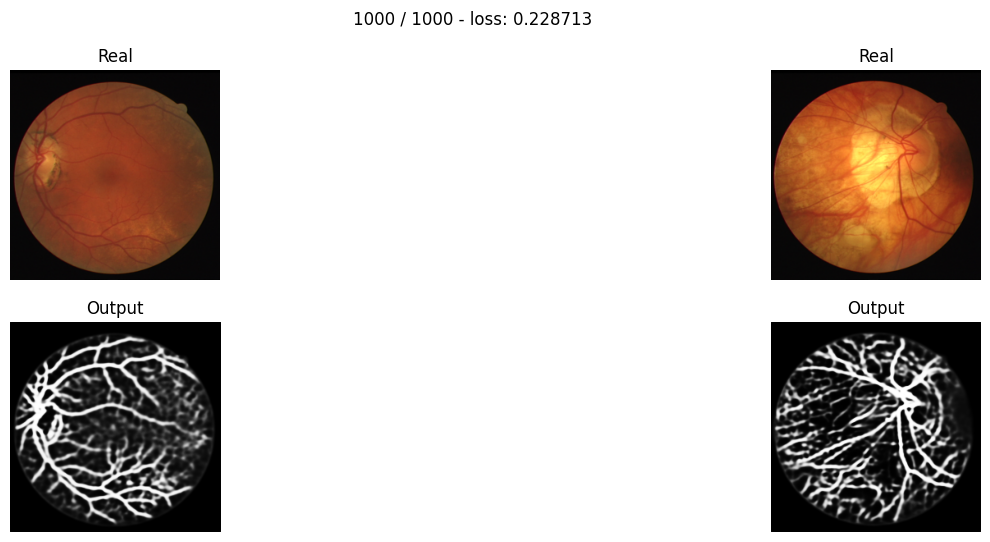

In [15]:
# Train the encoder-decoder net with skip connections and bilinear in the upsampler
model = EncDec_skipconnections().to(device)
#model = EncDec().to(device)

epoch = 1000
criterion = bce_loss
lr = 0.0001
weight_decay = 0.001


#uncomment like the example below to train and validate (with IoU right now) (cannot currently validate both at once since it was a quick and dirty implementation)
test_loader = test_loader_drive
train_drive(model, optim.Adam(model.parameters(),lr, weight_decay=weight_decay), criterion, epoch, train_loader_drive, val_loader_drive)


#val_loader = test_loader_ph2
#train_ph2(model, optim.Adam(model.parameters(),lr, weight_decay=weight_decay), criterion, epoch, train_loader_ph2, val_loader_ph2)

In [16]:
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
         MaxPool2d-2         [-1, 64, 128, 128]               0
            Conv2d-3        [-1, 128, 128, 128]          73,856
         MaxPool2d-4          [-1, 128, 64, 64]               0
            Conv2d-5          [-1, 256, 64, 64]         295,168
         MaxPool2d-6          [-1, 256, 32, 32]               0
            Conv2d-7          [-1, 512, 32, 32]       1,180,160
         MaxPool2d-8          [-1, 512, 16, 16]               0
            Conv2d-9         [-1, 1024, 16, 16]       4,719,616
         Upsample-10         [-1, 1024, 32, 32]               0
           Conv2d-11          [-1, 512, 32, 32]       7,078,400
         Upsample-12          [-1, 512, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]       1,769,728
         Upsample-14        [-1, 256, 1

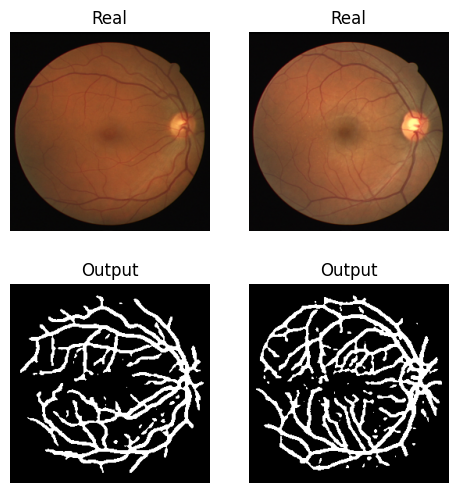

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# Load a batch from the validation loader
X_test, Y_test = next(iter(test_loader))

# Set the model to evaluation mode
model.eval()


Y_hat = F.sigmoid(model(X_test.to(device))).detach().cpu()

# Binarization for the pred mask

Y_hat = (Y_hat > 0.5).float() 

# Clear previous plots
clear_output(wait=True)

# Show real and predicted outputs, shows only two for both the datasets but can manually be adjusted but this was a sanity check to make sure the output mask was correct.
for k in range(2):
    plt.subplot(2, 6, k+1)
    plt.imshow(np.rollaxis(X_test[k].cpu().numpy(), 0, 3), cmap='gray')
    plt.title('Real')
    plt.axis('off')

    plt.subplot(2, 6, k+7)
    plt.imshow(Y_hat[k, 0].cpu().numpy(), cmap='gray')  # Assuming you want the first channel
    plt.title('Output')
    plt.axis('off')

plt.show()

### Metric for IoU for testing purposes 

In [38]:
# Validate the model
model.eval()

# JaccardIndex is the same as the IoU, so I used this as a quick intermediate to see if result was meaningful.
!pip install torchmetrics
from torchmetrics.classification import BinaryJaccardIndex

metric = BinaryJaccardIndex().to(device)

avg_iou = 0
num_samples = 0 

for X_batch, Y_batch in test_loader:
    X_batch = X_batch.to(device)
    Y_batch = Y_batch.to(device)

    Y_pred = F.sigmoid(model(X_batch))
    
    # Binarization of model output
    output = torch.mean(Y_pred, dim=1, keepdim=True)  # Convert 3 channels to 1 since EncDec has 3 channel ouput (can be changed)
    Y_pred = (output > 0.5).float() 

    # IoU over the batch for each prediction
    batch_iou = 0
    for i in range(len(Y_batch)):
        iou = metric(Y_pred[i], Y_batch[i])
        batch_iou += iou

    # Bookkeeping
    avg_iou += batch_iou
    num_samples += len(Y_batch)

avg_iou /= num_samples  
print(f'Average IoU: {round(avg_iou.item(), 4)}') # note: 0.5 is a "good" score for IoU. 

Average IoU: 0.6342


C:\Users\Frederik\AppData\Local\Temp\ipykernel_24944\4291406222.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)
